In [1]:
from google.colab import files
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

import cv2
print(cv2.__version__)
# example of face detection with opencv cascade classifier
from cv2 import imread
from cv2 import rectangle
from cv2 import imshow
from PIL import Image 
import os

import pandas as pd

from sklearn.metrics import confusion_matrix



4.1.2


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
master_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Dataset'

age_classes = ['0-2','3-6','7-12','13-20','21-32','33-43','44-53','53-100+']

#**1. Get Data Loaders**

In [19]:
# Quick check 
count = 0
age_group = '0-2'
folder_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features/Debug_PreCropped6/' + age_group
for selectedFile in os.listdir(folder_path):
  count += 1

count2 = 0
age_group2 = '3-6'
folder_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Dataset/Debug_PreCropped6/' + age_group2
for selectedFile in os.listdir(folder_path):
  count2 += 1

print(count)
print(count2)

1005
952


In [7]:
def get_data_loader(batch_size):
    """ Loads images, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    """
    np.random.seed(1000)
    
    transform = transforms.Compose(
        [ transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.ImageFolder(root=master_path+'/balance helper',
                                                    transform=transform)
    
    age_classes = dataset.classes
    
    num_workers = 1
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=num_workers,shuffle = True)
    return data_loader,age_classes

In [8]:
def get_visualization(train_loader,age_classes):
  #Visualize some of the data
  k = 0
  print('classes=',age_classes)
  for i,(images,labels) in enumerate(train_loader,0):
    image = images[0]
    # # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.title(age_classes[labels.numpy()[0]])
    plt.imshow(img)
  

    k += 1
    if k > 14:
        break

##**1.2 Training, validation, test dataloader**

In [9]:
data_loader,age_classes = get_data_loader(1)
print("All data:", len(data_loader))


All data: 188


classes= ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']


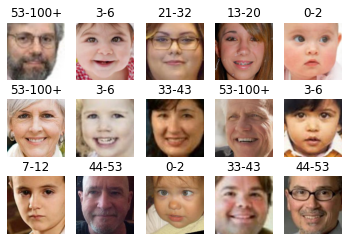

In [ ]:
get_visualization(data_loader,age_classes)

#**2. Extract Features using AlexNet**

Import AlexNet neural network for transfer learning:

In [10]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Viewing the Alexnet CNN network description:

In [ ]:
# Model description
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##**2.1 Extract Features**

Use alexnet.features to extract features. 

In [11]:
feature_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features/Debug_PreCropped6'

####**Bug** : the n will be different for every image each time. So the code below will create new tensor everytime

In [12]:
def extract_features(data_loader,path,age_classes):
  n = 0
  for img, label in data_loader:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = path + '/' + str(age_classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1

###**2.1.1 Features for small dataset**

**Before fixing the bug, DON'T DON't DON't run this part again**

In [ ]:
extract_features(train_loader_small,smalldata_path,age_classes_small)

###**2.1.2 Features for train, val and test**

**Before fixing the bug, DON'T DON't DON't run this part again**

In [18]:
extract_features(data_loader,feature_path,age_classes) 

###**Test dataset for the model of cross validation**

In [ ]:
transform = transforms.Compose(
        [ transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = torchvision.datasets.ImageFolder(root='/content/gdrive/My Drive/APS360 Group9 Project/Project/Dataset/Test_PreCropped',
                                                    transform=transform)
    
age_classes_test = dataset.classes
batch_size=1

num_workers = 1
data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=num_workers,shuffle = True)

classes= ['0-2', '13-20', '21-32', '3-6', '33-43', '44-53', '53-100+', '7-12']


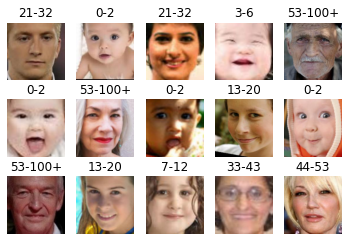

In [ ]:
get_visualization(data_loader_test,age_classes_test)

In [ ]:
test_path = '/content/gdrive/My Drive/APS360 Group9 Project/Project/Features/PreCropped_Test'

In [ ]:
extract_features(data_loader_test,test_path,age_classes_test) 